In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-to-mri-cgan/Dataset/sources.txt
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1860.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1979.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri99.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri478.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1608.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1379.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri2058.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1589.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri678.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri2440.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri959.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri750.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1628.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri2288.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri699.jpg
/kaggle/input/ct-to-mri-cgan

In [2]:
# %% 1) Setup and Dependencies
try:
    import pytorch_fid
    import lpips
    import pydicom
    import torchmetrics
    import cv2
except Exception:
    !pip install --quiet pytorch-fid lpips pydicom torchmetrics opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 100.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.8 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install --quiet --upgrade --force-reinstall \
    numpy==1.26.4 \
    scikit-learn==1.3.2 \
    scipy==1.13.1 \
    protobuf==4.25.3 \
    huggingface-hub==0.24.6 \
    transformers==4.41.2 \
    pyarrow==15.0.2 \
    matplotlib==3.8.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 106.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 45.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 109.0 MB/s eta 0:00:0000:0100:01


In [6]:
# %% 2) Imports & device
import os, glob, random, time, csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import cv2 # Added for Grad-CAM visualization utility

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from torchvision.utils import save_image, make_grid
from skimage.metrics import mean_squared_error, normalized_root_mse
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# FID & LPIPS
from pytorch_fid.fid_score import calculate_fid_given_paths
import lpips
import pydicom

In [7]:
# Define device and initialize LPIPS metrics globally
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_lpips = lpips.LPIPS(net='alex').to(device)

def calculate_mse_rmse(img1, img2):
    """Calculates MSE and RMSE for normalized torch tensors in [-1, 1]."""
    # Convert from torch tensor [-1, 1] to numpy [0, 1]
    img1_np = ((img1.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2).mean(axis=2)
    img2_np = ((img2.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2).mean(axis=2)
    
    mse = mean_squared_error(img1_np, img2_np)
    rmse = np.sqrt(mse)
    return mse, rmse

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 230MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [10]:
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

print('Device:', device)

# Point DATA_ROOT to ct-to-mri-cgan images folder on Kaggle
DATA_ROOT = '/kaggle/input/ct-to-mri-cgan/Dataset/images'

# Image / training hyperparameters (keep as before or tweak)
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_WORKERS = 2
N_EPOCHS = 100
LR = 2e-4
BETA1, BETA2 = 0.5, 0.999
POOL_SIZE = 50
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 5.0
SAVE_EVERY = 5

# Output folders
OUT_DIR = '/kaggle/working/cyclegan_outputs'
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'samples'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'plots'), exist_ok=True)

# dataset folders (A: CT, B: MRI)
# We adopt the convention: A = CT, B = MRI
TRAIN_A = os.path.join(DATA_ROOT, 'trainA')   # CT train
TRAIN_B = os.path.join(DATA_ROOT, 'trainB')   # MRI train
TEST_A  = os.path.join(DATA_ROOT, 'testA')    # CT test
TEST_B  = os.path.join(DATA_ROOT, 'testB')    
# Main variables (keep old names used by the notebook where appropriate)
CT_FOLDER = TRAIN_A
MR_FOLDER = TRAIN_B
CT_TEST_FOLDER = TEST_A
MR_TEST_FOLDER = TEST_B

print('CT (train) folder =', CT_FOLDER)
print('MR (train) folder =', MR_FOLDER)
print('CT (test) folder =', CT_TEST_FOLDER)
print('MR (test) folder =', MR_TEST_FOLDER)

# sanity checks
for p in [CT_FOLDER, MR_FOLDER, CT_TEST_FOLDER, MR_TEST_FOLDER]:
    if not os.path.isdir(p):
        raise RuntimeError(f"Required folder not found: {p}")

writer = SummaryWriter(log_dir=os.path.join(OUT_DIR, 'logs'))

# metrics CSV init
metrics_csv = os.path.join(OUT_DIR, 'metrics.csv')
with open(metrics_csv, 'w', newline='') as f:
    writer_csv = csv.writer(f)
    writer_csv.writerow(['epoch','iteration','loss_G','loss_D_A','loss_D_B',
                         'loss_id_A','loss_id_B','loss_gan_A2B','loss_gan_B2A',
                         'loss_cycle_A','loss_cycle_B','lr','fid','lpips','psnr','ssim'])

Device: cuda
CT (train) folder = /kaggle/input/ct-to-mri-cgan/Dataset/images/trainA
MR (train) folder = /kaggle/input/ct-to-mri-cgan/Dataset/images/trainB
CT (test) folder = /kaggle/input/ct-to-mri-cgan/Dataset/images/testA
MR (test) folder = /kaggle/input/ct-to-mri-cgan/Dataset/images/testB


In [11]:
from PIL import Image

def pil_to_rgb(img):
    """Ensure a PIL image is RGB (3 channels)."""
    if img.mode == 'RGB':
        return img
    else:
        return img.convert('RGB')

class UnpairedImageDataset(Dataset):
    """
    Unpaired dataset for CycleGAN-like training.
    Expects two folders dir_A and dir_B containing images (png/jpg/jpeg).
    Returns dict with 'A' and 'B' images (transformed).
    """
    def __init__(self, dir_A, dir_B, transform=None, extensions=('.png', '.jpg', '.jpeg')):
        self.A_paths = sorted([os.path.join(dir_A, f) for f in os.listdir(dir_A)
                               if f.lower().endswith(extensions)])
        self.B_paths = sorted([os.path.join(dir_B, f) for f in os.listdir(dir_B)
                               if f.lower().endswith(extensions)])
        if len(self.A_paths) == 0:
            raise RuntimeError(f'No images in A folder: {dir_A}')
        if len(self.B_paths) == 0:
            raise RuntimeError(f'No images in B folder: {dir_B}')
        self.transform = transform

    def __len__(self):
        return max(len(self.A_paths), len(self.B_paths))

    def __getitem__(self, idx):
        a_path = self.A_paths[idx % len(self.A_paths)]
        b_path = self.B_paths[random.randrange(len(self.B_paths))]  # unpaired: random B

        img_A = pil_to_rgb(Image.open(a_path))
        img_B = pil_to_rgb(Image.open(b_path))

        if self.transform is not None:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
        else:
            # fallback transforms: resize + to tensor normalized to [-1,1]
            tf = T.Compose([
                T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                T.ToTensor(),
                T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
            ])
            img_A = tf(img_A)
            img_B = tf(img_B)

        return {'A': img_A, 'B': img_B, 'A_path': a_path, 'B_path': b_path}


In [12]:
# Transforms and DataLoaders for ct-to-mri images

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),   # optional augmentation
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # map to [-1,1]
])

train_dataset = UnpairedImageDataset(CT_FOLDER, MR_FOLDER, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)

# Test loaders (unpaired) - useful for evaluation and visualization
test_dataset_A = sorted([os.path.join(CT_TEST_FOLDER, f) for f in os.listdir(CT_TEST_FOLDER)
                       if f.lower().endswith(('.png','.jpg','.jpeg'))])
test_dataset_B = sorted([os.path.join(MR_TEST_FOLDER, f) for f in os.listdir(MR_TEST_FOLDER)
                       if f.lower().endswith(('.png','.jpg','.jpeg'))])

print(f"Train size A (CT): {len(train_dataset.A_paths)} | Train size B (MR): {len(train_dataset.B_paths)}")
print(f"Test size A (CT): {len(test_dataset_A)} | Test size B (MR): {len(test_dataset_B)}")


Train size A (CT): 1742 | Train size B (MR): 1744
Test size A (CT): 744 | Test size B (MR): 744


In [14]:
# %% 6) Models (same as before: ResNet generator and PatchGAN discriminator)
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        block = []
        block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, bias=False), nn.InstanceNorm2d(dim), nn.ReLU(True)]
        block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, bias=False), nn.InstanceNorm2d(dim)]
        self.block = nn.Sequential(*block)

    def forward(self, x):
        return x + self.block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=6):
        super().__init__()
        model = []
        model += [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, bias=False), nn.InstanceNorm2d(ngf), nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=False),
                      nn.InstanceNorm2d(ngf * mult * 2), nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                      nn.InstanceNorm2d(int(ngf * mult / 2)), nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super().__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]

        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)

def init_weights(net, init_type='normal', init_gain=0.02):
    def init_fun(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, init_gain)
            nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_fun)

In [16]:
# 7) Losses, networks, optimizers, schedulers, pools
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

netG_A2B = ResnetGenerator(3, 3, ngf=64, n_blocks=6).to(device)
netG_B2A = ResnetGenerator(3, 3, ngf=64, n_blocks=6).to(device)
netD_A = NLayerDiscriminator(3).to(device)
netD_B = NLayerDiscriminator(3).to(device)

init_weights(netG_A2B)
init_weights(netG_B2A)
init_weights(netD_A)
init_weights(netD_B)

optimizer_G = optim.Adam(list(netG_A2B.parameters()) + list(netG_B2A.parameters()), lr=LR, betas=(BETA1, BETA2))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=LR, betas=(BETA1, BETA2))

def lambda_rule(epoch):
    start_decay_epoch = int(N_EPOCHS / 2)
    if epoch < start_decay_epoch:
        return 1.0
    return 1.0 - float(epoch - start_decay_epoch) / (N_EPOCHS - start_decay_epoch + 1)

scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D_A = optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_rule)
scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_rule)

class ImagePool:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        if pool_size > 0:
            self.images = []
            self.num_imgs = 0

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs += 1
                self.images.append(image.clone())
                return_images.append(image)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.pool_size - 1)
                    tmp = self.images[idx].clone()
                    self.images[idx] = image.clone()
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return torch.cat(return_images, 0)

fake_A_pool = ImagePool(POOL_SIZE)
fake_B_pool = ImagePool(POOL_SIZE)

def make_target(pred, target_is_real=True):
    return torch.ones_like(pred, device=pred.device) if target_is_real else torch.zeros_like(pred, device=pred.device)

def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

In [18]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [20]:
print('Starting training with enhanced logging...')
iteration = 0

# Meters to smooth values for printing
meter_G = AverageMeter()
meter_D_A = AverageMeter()
meter_D_B = AverageMeter()
meter_id_A = AverageMeter()
meter_id_B = AverageMeter()
meter_gan_A2B = AverageMeter()
meter_gan_B2A = AverageMeter()
meter_cycle_A = AverageMeter()
meter_cycle_B = AverageMeter()

for epoch in range(1,N_EPOCHS+1):
    t0=time.time()
    netG_A2B.train(); netG_B2A.train(); netD_A.train(); netD_B.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{N_EPOCHS}")
    for i,data in loop:
        real_A,real_B=data['A'].to(device),data['B'].to(device)

        # ---- Train Generators ----
        optimizer_G.zero_grad()

        # identity
        same_B = netG_A2B(real_B)
        loss_id_B = criterion_identity(same_B, real_B) * LAMBDA_IDENTITY
        same_A = netG_B2A(real_A)
        loss_id_A = criterion_identity(same_A, real_A) * LAMBDA_IDENTITY

        # GAN
        fake_B = netG_A2B(real_A)
        pred_fake_B = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake_B, make_target(pred_fake_B, True))

        fake_A = netG_B2A(real_B)
        pred_fake_A = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake_A, make_target(pred_fake_A, True))

        # cycle
        rec_A = netG_B2A(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A) * LAMBDA_CYCLE
        rec_B = netG_A2B(fake_A)
        loss_cycle_B = criterion_cycle(rec_B, real_B) * LAMBDA_CYCLE

        loss_G = loss_id_A + loss_id_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B
        loss_G.backward()
        optimizer_G.step()

        # ---- Train Discriminator A ----
        optimizer_D_A.zero_grad()
        pred_real_A = netD_A(real_A)
        loss_D_real_A = criterion_GAN(pred_real_A, make_target(pred_real_A, True))

        fake_A_det = fake_A_pool.query(fake_A.detach())
        pred_fake_A = netD_A(fake_A_det)
        loss_D_fake_A = criterion_GAN(pred_fake_A, make_target(pred_fake_A, False))

        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # ---- Train Discriminator B ----
        optimizer_D_B.zero_grad()
        pred_real_B = netD_B(real_B)
        loss_D_real_B = criterion_GAN(pred_real_B, make_target(pred_real_B, True))

        fake_B_det = fake_B_pool.query(fake_B.detach())
        pred_fake_B = netD_B(fake_B_det)
        loss_D_fake_B = criterion_GAN(pred_fake_B, make_target(pred_fake_B, False))

        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # update iteration counters and meters
        iteration += 1
        meter_G.update(loss_G.item())
        meter_D_A.update(loss_D_A.item())
        meter_D_B.update(loss_D_B.item())
        meter_id_A.update(loss_id_A.item())
        meter_id_B.update(loss_id_B.item())
        meter_gan_A2B.update(loss_GAN_A2B.item())
        meter_gan_B2A.update(loss_GAN_B2A.item())
        meter_cycle_A.update(loss_cycle_A.item())
        meter_cycle_B.update(loss_cycle_B.item())

        # TensorBoard per-iteration logging (sample every 50 iters)
        if iteration % 50 == 0:
            writer.add_scalar('Loss/loss_G', meter_G.avg, iteration)
            writer.add_scalar('Loss/loss_D_A', meter_D_A.avg, iteration)
            writer.add_scalar('Loss/loss_D_B', meter_D_B.avg, iteration)
            writer.add_scalar('LR/lr_G', get_lr(optimizer_G), iteration)

        if iteration%500==0:
            with torch.no_grad():
                sample=torch.cat([real_A[:2],fake_B[:2],real_B[:2],fake_A[:2]],0)
                sample_img=(sample+1)/2.0
                grid_img=make_grid(sample_img,nrow=2,padding=2,normalize=False)  # ✅ FIXED
                save_image(sample_img,os.path.join(OUT_DIR,'samples',f'iter_{iteration}.png'),nrow=2)
                writer.add_image('Samples/iter',grid_img,iteration)

        # update tqdm display
        loop.set_postfix({
            'G': f'{meter_G.avg:.4f}',
            'D_A': f'{meter_D_A.avg:.4f}',
            'D_B': f'{meter_D_B.avg:.4f}'
        })

    # end of epoch: scheduler step
    scheduler_G.step()
    scheduler_D_A.step()
    scheduler_D_B.step()

    # save checkpoint every SAVE_EVERY epochs
    if epoch % SAVE_EVERY == 0 or epoch == N_EPOCHS:
        ckpt_path = os.path.join(OUT_DIR, 'checkpoints', f'ckpt_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'netG_A2B': netG_A2B.state_dict(),
            'netG_B2A': netG_B2A.state_dict(),
            'netD_A': netD_A.state_dict(),
            'netD_B': netD_B.state_dict(),
            'optim_G': optimizer_G.state_dict()
        }, ckpt_path)

    # Log epoch metrics to CSV (only training losses here)
    with open(metrics_csv, 'a', newline='') as f:
        writer_csv = csv.writer(f)
        writer_csv.writerow([
            epoch, iteration, meter_G.avg, meter_D_A.avg, meter_D_B.avg,
            meter_id_A.avg, meter_id_B.avg, meter_gan_A2B.avg, meter_gan_B2A.avg,
            meter_cycle_A.avg, meter_cycle_B.avg, get_lr(optimizer_G),
            '', '', '', ''  # placeholders for FID/LPIPS/PSNR/SSIM
        ])

    # print epoch summary
    t1 = time.time()
    print(f"Epoch {epoch} finished in {t1-t0:.1f}s - G: {meter_G.avg:.4f}, D_A: {meter_D_A.avg:.4f}, D_B: {meter_D_B.avg:.4f}")

print('Training finished.')
writer.close()

Starting training with enhanced logging...


Epoch 1/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=4.6085, D_A=0.3127, D_B=0.3098]

Epoch 1 finished in 375.0s - G: 4.6085, D_A: 0.3127, D_B: 0.3098



Epoch 2/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=4.2213, D_A=0.2604, D_B=0.2634]

Epoch 2 finished in 374.6s - G: 4.2213, D_A: 0.2604, D_B: 0.2634



Epoch 3/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=4.0323, D_A=0.2427, D_B=0.2442]

Epoch 3 finished in 374.4s - G: 4.0323, D_A: 0.2427, D_B: 0.2442



Epoch 4/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.9364, D_A=0.2295, D_B=0.2303]

Epoch 4 finished in 374.3s - G: 3.9364, D_A: 0.2295, D_B: 0.2303



Epoch 5/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=3.8490, D_A=0.2258, D_B=0.2204]


Epoch 5 finished in 374.5s - G: 3.8490, D_A: 0.2258, D_B: 0.2204


Epoch 6/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=3.7976, D_A=0.2173, D_B=0.2096]

Epoch 6 finished in 374.3s - G: 3.7976, D_A: 0.2173, D_B: 0.2096



Epoch 7/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.7432, D_A=0.2103, D_B=0.2026]

Epoch 7 finished in 374.4s - G: 3.7432, D_A: 0.2103, D_B: 0.2026



Epoch 8/100: 100%|██████████| 436/436 [06:13<00:00,  1.17it/s, G=3.7011, D_A=0.2040, D_B=0.1960]

Epoch 8 finished in 373.9s - G: 3.7011, D_A: 0.2040, D_B: 0.1960



Epoch 9/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=3.6584, D_A=0.2000, D_B=0.1908]

Epoch 9 finished in 374.3s - G: 3.6584, D_A: 0.2000, D_B: 0.1908



Epoch 10/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.6219, D_A=0.1957, D_B=0.1858]


Epoch 10 finished in 374.6s - G: 3.6219, D_A: 0.1957, D_B: 0.1858


Epoch 11/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=3.5859, D_A=0.1910, D_B=0.1824]

Epoch 11 finished in 374.2s - G: 3.5859, D_A: 0.1910, D_B: 0.1824



Epoch 12/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=3.5470, D_A=0.2130, D_B=0.1799]

Epoch 12 finished in 374.3s - G: 3.5470, D_A: 0.2130, D_B: 0.1799



Epoch 13/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.4745, D_A=0.2153, D_B=0.1842]

Epoch 13 finished in 374.4s - G: 3.4745, D_A: 0.2153, D_B: 0.1842



Epoch 14/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=3.4001, D_A=0.2175, D_B=0.1840]

Epoch 14 finished in 374.3s - G: 3.4001, D_A: 0.2175, D_B: 0.1840



Epoch 15/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=3.3418, D_A=0.2193, D_B=0.1811]


Epoch 15 finished in 374.6s - G: 3.3418, D_A: 0.2193, D_B: 0.1811


Epoch 16/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=3.2933, D_A=0.2204, D_B=0.1788]

Epoch 16 finished in 374.1s - G: 3.2933, D_A: 0.2204, D_B: 0.1788



Epoch 17/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.2548, D_A=0.2211, D_B=0.1752]

Epoch 17 finished in 374.5s - G: 3.2548, D_A: 0.2211, D_B: 0.1752



Epoch 18/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.2233, D_A=0.2257, D_B=0.1731]

Epoch 18 finished in 374.4s - G: 3.2233, D_A: 0.2257, D_B: 0.1731



Epoch 19/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.1771, D_A=0.2258, D_B=0.1723]

Epoch 19 finished in 374.5s - G: 3.1771, D_A: 0.2258, D_B: 0.1723



Epoch 20/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.1452, D_A=0.2255, D_B=0.1700]


Epoch 20 finished in 374.7s - G: 3.1452, D_A: 0.2255, D_B: 0.1700


Epoch 21/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.1157, D_A=0.2252, D_B=0.1680]

Epoch 21 finished in 374.5s - G: 3.1157, D_A: 0.2252, D_B: 0.1680



Epoch 22/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.0842, D_A=0.2246, D_B=0.1703]

Epoch 22 finished in 374.4s - G: 3.0842, D_A: 0.2246, D_B: 0.1703



Epoch 23/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=3.0441, D_A=0.2240, D_B=0.1720]

Epoch 23 finished in 374.4s - G: 3.0441, D_A: 0.2240, D_B: 0.1720



Epoch 24/100: 100%|██████████| 436/436 [06:13<00:00,  1.17it/s, G=3.0252, D_A=0.2234, D_B=0.1693]

Epoch 24 finished in 374.0s - G: 3.0252, D_A: 0.2234, D_B: 0.1693



Epoch 25/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=3.0071, D_A=0.2224, D_B=0.1672]


Epoch 25 finished in 374.5s - G: 3.0071, D_A: 0.2224, D_B: 0.1672


Epoch 26/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.9882, D_A=0.2212, D_B=0.1656]

Epoch 26 finished in 374.1s - G: 2.9882, D_A: 0.2212, D_B: 0.1656



Epoch 27/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.9839, D_A=0.2197, D_B=0.1610]

Epoch 27 finished in 374.2s - G: 2.9839, D_A: 0.2197, D_B: 0.1610



Epoch 28/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.9705, D_A=0.2180, D_B=0.1597]

Epoch 28 finished in 374.2s - G: 2.9705, D_A: 0.2180, D_B: 0.1597



Epoch 29/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.9547, D_A=0.2165, D_B=0.1588]

Epoch 29 finished in 374.3s - G: 2.9547, D_A: 0.2165, D_B: 0.1588



Epoch 30/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.9408, D_A=0.2150, D_B=0.1583]


Epoch 30 finished in 374.6s - G: 2.9408, D_A: 0.2150, D_B: 0.1583


Epoch 31/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.9313, D_A=0.2137, D_B=0.1561]

Epoch 31 finished in 374.3s - G: 2.9313, D_A: 0.2137, D_B: 0.1561



Epoch 32/100: 100%|██████████| 436/436 [06:13<00:00,  1.17it/s, G=2.9186, D_A=0.2125, D_B=0.1548]

Epoch 32 finished in 373.9s - G: 2.9186, D_A: 0.2125, D_B: 0.1548



Epoch 33/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.9038, D_A=0.2126, D_B=0.1534]

Epoch 33 finished in 374.2s - G: 2.9038, D_A: 0.2126, D_B: 0.1534



Epoch 34/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.8961, D_A=0.2113, D_B=0.1515]

Epoch 34 finished in 374.2s - G: 2.8961, D_A: 0.2113, D_B: 0.1515



Epoch 35/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.8825, D_A=0.2102, D_B=0.1523]


Epoch 35 finished in 374.4s - G: 2.8825, D_A: 0.2102, D_B: 0.1523


Epoch 36/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.8732, D_A=0.2089, D_B=0.1512]

Epoch 36 finished in 374.4s - G: 2.8732, D_A: 0.2089, D_B: 0.1512



Epoch 37/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.8670, D_A=0.2079, D_B=0.1503]

Epoch 37 finished in 374.3s - G: 2.8670, D_A: 0.2079, D_B: 0.1503



Epoch 38/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.8761, D_A=0.2064, D_B=0.1477]

Epoch 38 finished in 374.4s - G: 2.8761, D_A: 0.2064, D_B: 0.1477



Epoch 39/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.8724, D_A=0.2050, D_B=0.1463]

Epoch 39 finished in 374.4s - G: 2.8724, D_A: 0.2050, D_B: 0.1463



Epoch 40/100: 100%|██████████| 436/436 [06:13<00:00,  1.17it/s, G=2.8589, D_A=0.2044, D_B=0.1464]


Epoch 40 finished in 374.3s - G: 2.8589, D_A: 0.2044, D_B: 0.1464


Epoch 41/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.8500, D_A=0.2039, D_B=0.1455]

Epoch 41 finished in 374.5s - G: 2.8500, D_A: 0.2039, D_B: 0.1455



Epoch 42/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.8423, D_A=0.2031, D_B=0.1447]

Epoch 42 finished in 374.4s - G: 2.8423, D_A: 0.2031, D_B: 0.1447



Epoch 43/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.8334, D_A=0.2024, D_B=0.1438]

Epoch 43 finished in 374.4s - G: 2.8334, D_A: 0.2024, D_B: 0.1438



Epoch 44/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.8246, D_A=0.2018, D_B=0.1431]

Epoch 44 finished in 374.4s - G: 2.8246, D_A: 0.2018, D_B: 0.1431



Epoch 45/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.8154, D_A=0.2018, D_B=0.1467]


Epoch 45 finished in 374.7s - G: 2.8154, D_A: 0.2018, D_B: 0.1467


Epoch 46/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.7972, D_A=0.2012, D_B=0.1487]

Epoch 46 finished in 374.4s - G: 2.7972, D_A: 0.2012, D_B: 0.1487



Epoch 47/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.7801, D_A=0.2005, D_B=0.1506]

Epoch 47 finished in 374.1s - G: 2.7801, D_A: 0.2005, D_B: 0.1506



Epoch 48/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.7635, D_A=0.2001, D_B=0.1522]

Epoch 48 finished in 374.5s - G: 2.7635, D_A: 0.2001, D_B: 0.1522



Epoch 49/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.7491, D_A=0.2000, D_B=0.1528]

Epoch 49 finished in 374.5s - G: 2.7491, D_A: 0.2000, D_B: 0.1528



Epoch 50/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.7411, D_A=0.1995, D_B=0.1525]


Epoch 50 finished in 374.7s - G: 2.7411, D_A: 0.1995, D_B: 0.1525


Epoch 51/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.7365, D_A=0.1990, D_B=0.1511]

Epoch 51 finished in 374.5s - G: 2.7365, D_A: 0.1990, D_B: 0.1511



Epoch 52/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.7296, D_A=0.1983, D_B=0.1505]

Epoch 52 finished in 374.5s - G: 2.7296, D_A: 0.1983, D_B: 0.1505



Epoch 53/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.7205, D_A=0.1980, D_B=0.1501]

Epoch 53 finished in 374.5s - G: 2.7205, D_A: 0.1980, D_B: 0.1501



Epoch 54/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.7145, D_A=0.1974, D_B=0.1495]

Epoch 54 finished in 374.5s - G: 2.7145, D_A: 0.1974, D_B: 0.1495



Epoch 55/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.7084, D_A=0.1971, D_B=0.1483]


Epoch 55 finished in 374.4s - G: 2.7084, D_A: 0.1971, D_B: 0.1483


Epoch 56/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.7008, D_A=0.1968, D_B=0.1474]

Epoch 56 finished in 374.4s - G: 2.7008, D_A: 0.1968, D_B: 0.1474



Epoch 57/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.6927, D_A=0.1965, D_B=0.1469]

Epoch 57 finished in 374.4s - G: 2.6927, D_A: 0.1965, D_B: 0.1469



Epoch 58/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.6864, D_A=0.1960, D_B=0.1465]

Epoch 58 finished in 374.5s - G: 2.6864, D_A: 0.1960, D_B: 0.1465



Epoch 59/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.6818, D_A=0.1958, D_B=0.1452]

Epoch 59 finished in 374.3s - G: 2.6818, D_A: 0.1958, D_B: 0.1452



Epoch 60/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.6739, D_A=0.1955, D_B=0.1445]


Epoch 60 finished in 374.6s - G: 2.6739, D_A: 0.1955, D_B: 0.1445


Epoch 61/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.6649, D_A=0.1953, D_B=0.1443]

Epoch 61 finished in 374.5s - G: 2.6649, D_A: 0.1953, D_B: 0.1443



Epoch 62/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.6581, D_A=0.1951, D_B=0.1434]

Epoch 62 finished in 374.4s - G: 2.6581, D_A: 0.1951, D_B: 0.1434



Epoch 63/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.6541, D_A=0.1955, D_B=0.1420]

Epoch 63 finished in 374.2s - G: 2.6541, D_A: 0.1955, D_B: 0.1420



Epoch 64/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.6472, D_A=0.1951, D_B=0.1450]

Epoch 64 finished in 374.5s - G: 2.6472, D_A: 0.1951, D_B: 0.1450



Epoch 65/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.6340, D_A=0.1946, D_B=0.1467]


Epoch 65 finished in 374.8s - G: 2.6340, D_A: 0.1946, D_B: 0.1467


Epoch 66/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.6196, D_A=0.1943, D_B=0.1482]

Epoch 66 finished in 374.5s - G: 2.6196, D_A: 0.1943, D_B: 0.1482



Epoch 67/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.6059, D_A=0.1941, D_B=0.1497]

Epoch 67 finished in 374.5s - G: 2.6059, D_A: 0.1941, D_B: 0.1497



Epoch 68/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.5928, D_A=0.1937, D_B=0.1512]

Epoch 68 finished in 374.5s - G: 2.5928, D_A: 0.1937, D_B: 0.1512



Epoch 69/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.5800, D_A=0.1934, D_B=0.1526]

Epoch 69 finished in 374.5s - G: 2.5800, D_A: 0.1934, D_B: 0.1526



Epoch 70/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.5677, D_A=0.1930, D_B=0.1539]


Epoch 70 finished in 374.7s - G: 2.5677, D_A: 0.1930, D_B: 0.1539


Epoch 71/100: 100%|██████████| 436/436 [06:13<00:00,  1.17it/s, G=2.5546, D_A=0.1937, D_B=0.1551]

Epoch 71 finished in 374.1s - G: 2.5546, D_A: 0.1937, D_B: 0.1551



Epoch 72/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.5396, D_A=0.1940, D_B=0.1562]

Epoch 72 finished in 374.5s - G: 2.5396, D_A: 0.1940, D_B: 0.1562



Epoch 73/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.5294, D_A=0.1937, D_B=0.1565]

Epoch 73 finished in 374.5s - G: 2.5294, D_A: 0.1937, D_B: 0.1565



Epoch 74/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.5219, D_A=0.1934, D_B=0.1559]

Epoch 74 finished in 374.4s - G: 2.5219, D_A: 0.1934, D_B: 0.1559



Epoch 75/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.5163, D_A=0.1928, D_B=0.1551]


Epoch 75 finished in 374.6s - G: 2.5163, D_A: 0.1928, D_B: 0.1551


Epoch 76/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.5096, D_A=0.1924, D_B=0.1543]

Epoch 76 finished in 374.4s - G: 2.5096, D_A: 0.1924, D_B: 0.1543



Epoch 77/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.5024, D_A=0.1920, D_B=0.1537]

Epoch 77 finished in 374.4s - G: 2.5024, D_A: 0.1920, D_B: 0.1537



Epoch 78/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.4971, D_A=0.1917, D_B=0.1528]

Epoch 78 finished in 374.5s - G: 2.4971, D_A: 0.1917, D_B: 0.1528



Epoch 79/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4899, D_A=0.1914, D_B=0.1525]

Epoch 79 finished in 374.1s - G: 2.4899, D_A: 0.1914, D_B: 0.1525



Epoch 80/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4844, D_A=0.1910, D_B=0.1516]


Epoch 80 finished in 374.6s - G: 2.4844, D_A: 0.1910, D_B: 0.1516


Epoch 81/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4784, D_A=0.1907, D_B=0.1509]

Epoch 81 finished in 374.2s - G: 2.4784, D_A: 0.1907, D_B: 0.1509



Epoch 82/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4748, D_A=0.1904, D_B=0.1497]

Epoch 82 finished in 374.2s - G: 2.4748, D_A: 0.1904, D_B: 0.1497



Epoch 83/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4697, D_A=0.1900, D_B=0.1489]

Epoch 83 finished in 374.2s - G: 2.4697, D_A: 0.1900, D_B: 0.1489



Epoch 84/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4634, D_A=0.1896, D_B=0.1484]

Epoch 84 finished in 374.3s - G: 2.4634, D_A: 0.1896, D_B: 0.1484



Epoch 85/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4575, D_A=0.1893, D_B=0.1477]


Epoch 85 finished in 374.6s - G: 2.4575, D_A: 0.1893, D_B: 0.1477


Epoch 86/100: 100%|██████████| 436/436 [06:13<00:00,  1.17it/s, G=2.4517, D_A=0.1890, D_B=0.1470]

Epoch 86 finished in 374.0s - G: 2.4517, D_A: 0.1890, D_B: 0.1470



Epoch 87/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4467, D_A=0.1887, D_B=0.1462]

Epoch 87 finished in 374.3s - G: 2.4467, D_A: 0.1887, D_B: 0.1462



Epoch 88/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4431, D_A=0.1884, D_B=0.1452]

Epoch 88 finished in 374.2s - G: 2.4431, D_A: 0.1884, D_B: 0.1452



Epoch 89/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.4390, D_A=0.1881, D_B=0.1441]

Epoch 89 finished in 374.4s - G: 2.4390, D_A: 0.1881, D_B: 0.1441



Epoch 90/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4347, D_A=0.1878, D_B=0.1431]


Epoch 90 finished in 374.5s - G: 2.4347, D_A: 0.1878, D_B: 0.1431


Epoch 91/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.4312, D_A=0.1875, D_B=0.1420]

Epoch 91 finished in 374.3s - G: 2.4312, D_A: 0.1875, D_B: 0.1420



Epoch 92/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4264, D_A=0.1872, D_B=0.1414]

Epoch 92 finished in 374.2s - G: 2.4264, D_A: 0.1872, D_B: 0.1414



Epoch 93/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4212, D_A=0.1869, D_B=0.1407]

Epoch 93 finished in 374.2s - G: 2.4212, D_A: 0.1869, D_B: 0.1407



Epoch 94/100: 100%|██████████| 436/436 [06:13<00:00,  1.17it/s, G=2.4164, D_A=0.1866, D_B=0.1399]

Epoch 94 finished in 373.9s - G: 2.4164, D_A: 0.1866, D_B: 0.1399



Epoch 95/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4118, D_A=0.1863, D_B=0.1392]


Epoch 95 finished in 374.5s - G: 2.4118, D_A: 0.1863, D_B: 0.1392


Epoch 96/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4061, D_A=0.1861, D_B=0.1387]

Epoch 96 finished in 374.2s - G: 2.4061, D_A: 0.1861, D_B: 0.1387



Epoch 97/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.4003, D_A=0.1858, D_B=0.1382]

Epoch 97 finished in 374.2s - G: 2.4003, D_A: 0.1858, D_B: 0.1382



Epoch 98/100: 100%|██████████| 436/436 [06:14<00:00,  1.17it/s, G=2.3943, D_A=0.1856, D_B=0.1378]

Epoch 98 finished in 374.2s - G: 2.3943, D_A: 0.1856, D_B: 0.1378



Epoch 99/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.3882, D_A=0.1854, D_B=0.1374]

Epoch 99 finished in 374.4s - G: 2.3882, D_A: 0.1854, D_B: 0.1374



Epoch 100/100: 100%|██████████| 436/436 [06:14<00:00,  1.16it/s, G=2.3819, D_A=0.1851, D_B=0.1372]


Epoch 100 finished in 374.7s - G: 2.3819, D_A: 0.1851, D_B: 0.1372
Training finished.


In [26]:
real_CT_folder = CT_FOLDER                     # folder with real CT images
real_MR_folder = MR_FOLDER                     # folder with real MRI images
generated_A2B_folder = os.path.join(OUT_DIR, 'generated_A2B')
os.makedirs(generated_A2B_folder, exist_ok=True)

In [27]:
def pil_to_rgb(img):
    return img.convert('RGB')

def generate_folder_from_images(netG, source_image_folder, out_folder, transform=None):
    """
    Uses the trained generator (A->B or B->A) to create translated images for all files in a folder.
    """
    os.makedirs(out_folder, exist_ok=True)
    image_paths = sorted([
        p for p in glob.glob(os.path.join(source_image_folder, '*'))
        if p.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    
    for p in tqdm(image_paths, desc=f'Generating -> {out_folder}'):
        pil_img = pil_to_rgb(Image.open(p)).resize((IMAGE_SIZE, IMAGE_SIZE))
        if transform is not None:
            x = transform(pil_img).unsqueeze(0).to(device)
        else:
            x = T.ToTensor()(T.Resize((IMAGE_SIZE, IMAGE_SIZE))(pil_img)).unsqueeze(0).to(device)
            x = x * 2.0 - 1.0
        with torch.no_grad():
            y = netG(x)
        save_image((y + 1) / 2.0, os.path.join(out_folder, os.path.basename(p).rsplit('.',1)[0] + '.png'))

# Example: Generate A->B (CT → MRI)
generate_folder_from_images(netG_A2B, CT_TEST_FOLDER, generated_A2B_folder, transform=transform)


Generating -> /kaggle/working/cyclegan_outputs/generated_A2B: 100%|██████████| 744/744 [00:31<00:00, 23.62it/s]


In [31]:
import os
from PIL import Image
from tqdm import tqdm

def resize_images_for_fid(folder, size=(256, 256)):
    """
    Resizes all PNG/JPG images in a folder to a fixed size (for FID consistency).
    Saves resized copies to /kaggle/working/, since /kaggle/input/ is read-only.
    """
    base_name = os.path.basename(folder.rstrip('/'))
    resized_dir = os.path.join("/kaggle/working", base_name + "_resized")
    os.makedirs(resized_dir, exist_ok=True)

    for img_name in tqdm(os.listdir(folder), desc=f"Resizing {base_name}"):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            src_path = os.path.join(folder, img_name)
            dst_path = os.path.join(resized_dir, img_name)
            try:
                img = Image.open(src_path).convert("RGB")
                img = img.resize(size, Image.BICUBIC)
                img.save(dst_path)
            except Exception as e:
                print(f"Skipping {img_name}: {e}")
    return resized_dir

# --- Apply to your generated & real folders ---
generated_resized = resize_images_for_fid(generated_A2B_folder, (256, 256))
real_resized = resize_images_for_fid(real_CT_folder, (256, 256))

# --- Then call your evaluation on resized folders ---
final_metrics = calculate_metrics_A2B(generated_resized, real_resized, n_eval=200)

print("\n✅ Evaluation complete! Results:")
print(final_metrics)


100%|██████████| 25/25 [00:00<00:00, 28.41it/s]


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth

✅ Evaluation complete! Results:
{'fid': 190.39019482718373, 'lpips_mean': 0.4759873180091381, 'psnr_mean': 10.043865098290462, 'ssim_mean': 0.28748899698257446, 'rmse_mean': 0.31675657629966736, 'mse_mean': 0.10174021124839783}


In [32]:
import os, glob, shutil, torch, numpy as np
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
from torchvision.utils import save_image
import lpips
from pytorch_fid.fid_score import calculate_fid_given_paths
from skimage.metrics import peak_signal_noise_ratio as psnr_fn
from skimage.metrics import structural_similarity as ssim_fn
import pandas as pd
def calculate_metrics_A2B(generated_folder, real_B_folder, n_eval=200):
    """
    generated_folder: folder with generated A->B images (png)
    real_B_folder: folder with real B images (MRI) to compare against (we sample n_eval images)
    returns: dict of metrics (fid, etc.)
    """
    gen_paths = sorted([
        p for p in glob.glob(os.path.join(generated_folder, '*.png'))
    ])
    real_paths = sorted([
        p for p in glob.glob(os.path.join(real_B_folder, '*'))
        if p.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    if len(gen_paths) == 0:
        raise RuntimeError(f"No generated images found in {generated_folder}")

    n = min(n_eval, len(gen_paths), len(real_paths))
    gen_sample = gen_paths[:n]
    real_sample = real_paths[:n]

    # Temporary folders for FID
    tmp_gen = os.path.join(OUT_DIR, 'tmp_gen_eval')
    tmp_real = os.path.join(OUT_DIR, 'tmp_real_eval')
    shutil.rmtree(tmp_gen, ignore_errors=True)
    shutil.rmtree(tmp_real, ignore_errors=True)
    os.makedirs(tmp_gen, exist_ok=True)
    os.makedirs(tmp_real, exist_ok=True)

    for i, p in enumerate(gen_sample):
        shutil.copy(p, os.path.join(tmp_gen, f'{i:05d}.png'))
    for i, p in enumerate(real_sample):
        shutil.copy(p, os.path.join(tmp_real, f'{i:05d}.png'))

    # --- FID ---
    try:
        fid_val = calculate_fid_given_paths([tmp_real, tmp_gen],
                                            batch_size=8, device=str(device), dims=2048)
    except Exception as e:
        print("FID calculation failed:", e)
        fid_val = None

    # --- LPIPS, PSNR, SSIM, RMSE, MSE ---
    lpips_alex = lpips.LPIPS(net='alex').to(device)
    psnr_vals, ssim_vals, lpips_vals, rmse_vals, mse_vals = [], [], [], [], []

    for gpath, rpath in zip(gen_sample, real_sample):
        g = np.array(pil_to_rgb(Image.open(gpath)).resize((IMAGE_SIZE, IMAGE_SIZE))).astype(np.float32) / 255.0
        r = np.array(pil_to_rgb(Image.open(rpath)).resize((IMAGE_SIZE, IMAGE_SIZE))).astype(np.float32) / 255.0
    
        psnr_vals.append(psnr_fn(r, g, data_range=1.0))
        ssim_vals.append(ssim_fn(r, g, data_range=1.0, channel_axis=2))
        rmse_vals.append(np.sqrt(np.mean((r - g) ** 2)))
        mse_vals.append(np.mean((r - g) ** 2))
    
        g_t = T.ToTensor()(g).unsqueeze(0).to(device) * 2.0 - 1.0
        r_t = T.ToTensor()(r).unsqueeze(0).to(device) * 2.0 - 1.0
        with torch.no_grad():
            lp = lpips_alex(g_t, r_t).item()
        lpips_vals.append(lp)

    shutil.rmtree(tmp_gen, ignore_errors=True)
    shutil.rmtree(tmp_real, ignore_errors=True)

    metrics = {
        'fid': fid_val,
        'lpips_mean': float(np.mean(lpips_vals)),
        'psnr_mean': float(np.mean(psnr_vals)),
        'ssim_mean': float(np.mean(ssim_vals)),
        'rmse_mean': float(np.mean(rmse_vals)),
        'mse_mean': float(np.mean(mse_vals))
    }
    return metrics

# -------------------------------
# Run metrics calculation
# -------------------------------
final_metrics = calculate_metrics_A2B(
    generated_A2B_folder,
    MR_TEST_FOLDER,  # compare generated MRI images with real MRI test images
    n_eval=min(len(os.listdir(generated_A2B_folder)), 200)
)

# Save metrics as CSV
metrics_df = pd.DataFrame([final_metrics])
metrics_df.to_csv(os.path.join(OUT_DIR, "metrics_A2B.csv"), index=False)

print("\n✅ Evaluation complete!")
print("Metrics summary:")
print(metrics_df)
print(f"\nAll results saved to: {OUT_DIR}")

  0%|          | 0/25 [00:00<?, ?it/s]


FID calculation failed: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  F

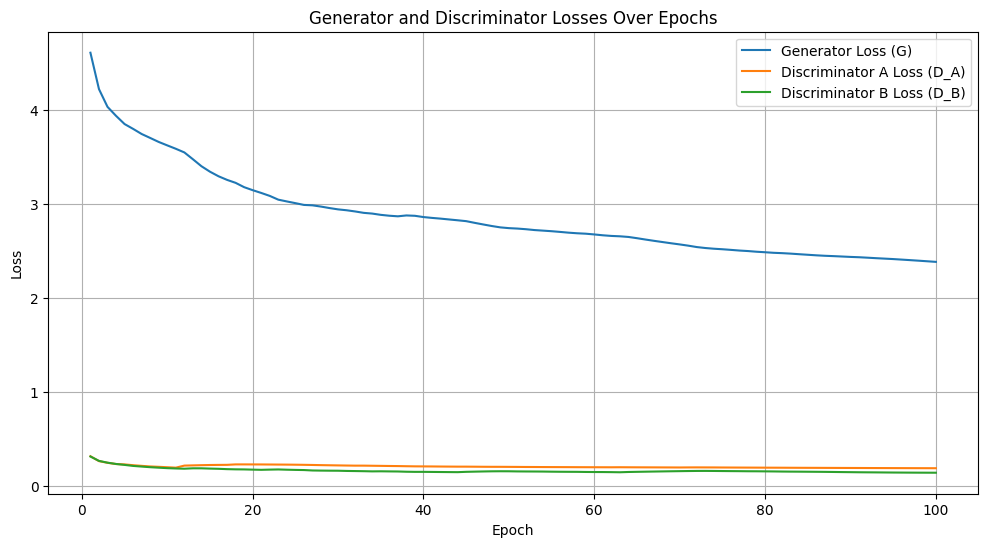

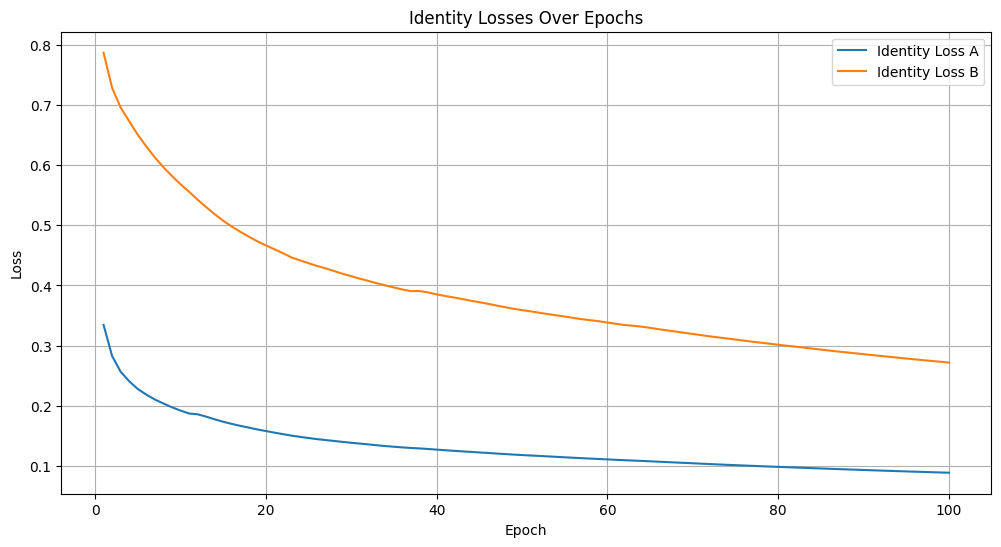

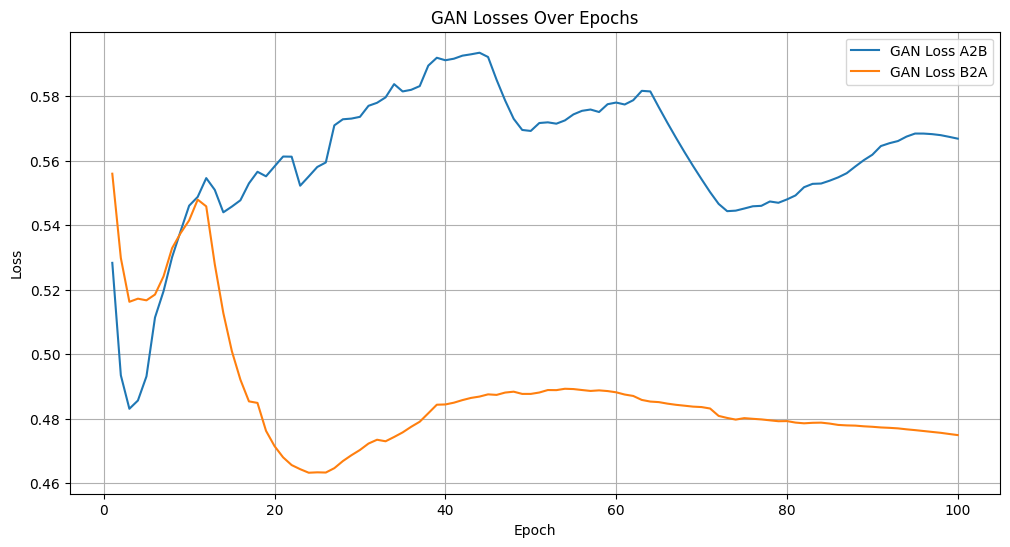

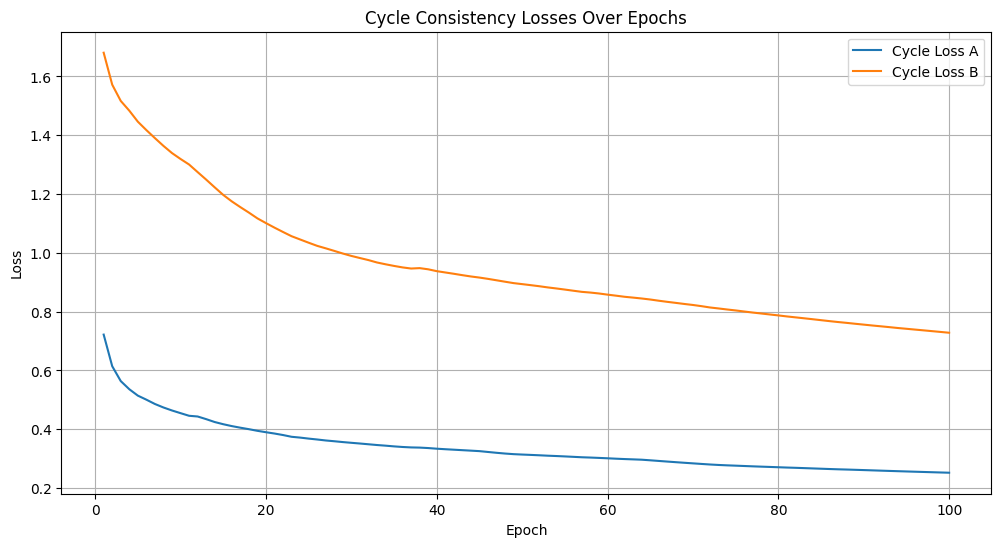

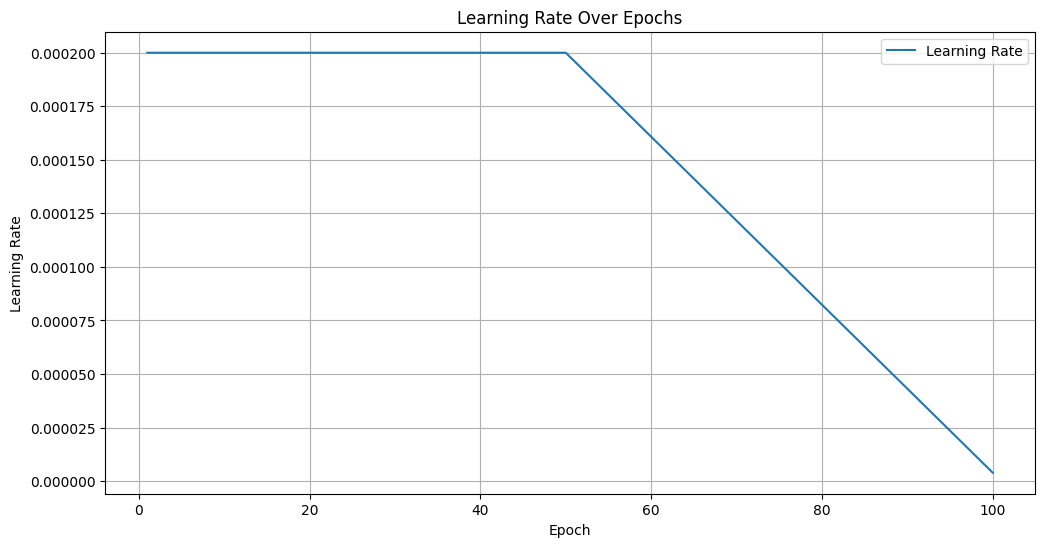

In [33]:
# %% 13) Visualization & Final Output

# Load updated metrics (assuming metrics_csv contains final IQA results on the last row)
metrics_df = pd.read_csv(metrics_csv)

# ------------------------------------------------------------------
# --- Loss Plots ---
# ------------------------------------------------------------------
os.makedirs(os.path.join(OUT_DIR, 'plots'), exist_ok=True)

# 1. Generator and Discriminator Losses
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_G'], label='Generator Loss (G)')
plt.plot(metrics_df['epoch'], metrics_df['loss_D_A'], label='Discriminator A Loss (D_A)')
plt.plot(metrics_df['epoch'], metrics_df['loss_D_B'], label='Discriminator B Loss (D_B)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Generator and Discriminator Losses Over Epochs')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'generator_discriminator_losses.png'), dpi=150)
plt.show()

# 2. Identity Losses
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_id_A'], label='Identity Loss A')
plt.plot(metrics_df['epoch'], metrics_df['loss_id_B'], label='Identity Loss B')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Identity Losses Over Epochs')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'identity_losses.png'), dpi=150)
plt.show()

# 3. GAN Losses
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_gan_A2B'], label='GAN Loss A2B')
plt.plot(metrics_df['epoch'], metrics_df['loss_gan_B2A'], label='GAN Loss B2A')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('GAN Losses Over Epochs')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'gan_losses.png'), dpi=150)
plt.show()

# 4. Cycle Losses
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_cycle_A'], label='Cycle Loss A')
plt.plot(metrics_df['epoch'], metrics_df['loss_cycle_B'], label='Cycle Loss B')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Cycle Consistency Losses Over Epochs')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'cycle_losses.png'), dpi=150)
plt.show()

# 5. Learning Rate
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['lr'], label='Learning Rate')
plt.xlabel('Epoch'); plt.ylabel('Learning Rate'); plt.title('Learning Rate Over Epochs')
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, 'plots', 'learning_rate.png'), dpi=150)
plt.show()

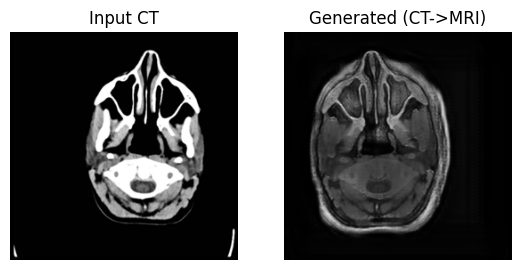

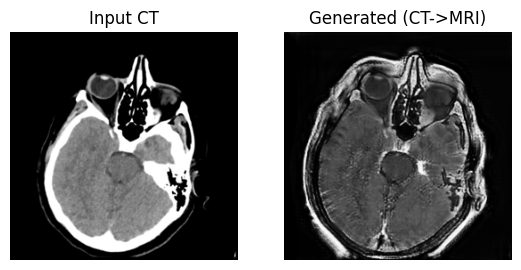

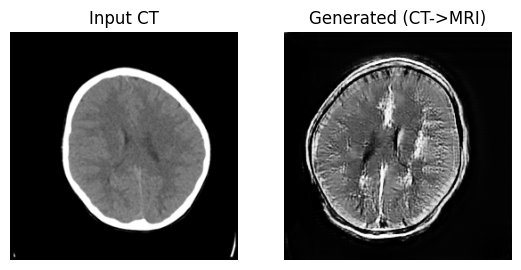

In [34]:
# --- Sample Visualization (Final Output Comparison) 
gen_folder = os.path.join(OUT_DIR, 'generated_A2B')

# choose a few CT test images to show input -> generated -> reference (if available)
ct_test_paths = sorted([p for p in glob.glob(os.path.join(CT_TEST_FOLDER, '*'))
                       if p.lower().endswith(('.png','.jpg','.jpeg'))])
n_show = min(3, len(ct_test_paths))
selected = ct_test_paths[:n_show]

for p in selected:
    pil_in = pil_to_rgb(Image.open(p)).resize((IMAGE_SIZE, IMAGE_SIZE))
    # generated path (we assume output name equals input basename with .png)
    gen_path = os.path.join(gen_folder, os.path.basename(p).rsplit('.',1)[0] + '.png')
    if os.path.exists(gen_path):
        pil_gen = pil_to_rgb(Image.open(gen_path)).resize((IMAGE_SIZE, IMAGE_SIZE))
    else:
        pil_gen = None

    # Show images
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.title("Input CT")
    plt.axis('off')
    plt.imshow(pil_in)
    if pil_gen is not None:
        plt.subplot(1,3,2)
        plt.title("Generated (CT->MRI)")
        plt.axis('off')
        plt.imshow(pil_gen)

    # try to show an MR reference if a similarly named file exists in MR test
    mr_ref_candidate = os.path.join(MR_TEST_FOLDER, os.path.basename(p).rsplit('.',1)[0] + '.png')
    if os.path.exists(mr_ref_candidate):
        pil_ref = pil_to_rgb(Image.open(mr_ref_candidate)).resize((IMAGE_SIZE, IMAGE_SIZE))
        plt.subplot(1,3,3)
        plt.title("Reference MRI (if paired)")
        plt.axis('off')
        plt.imshow(pil_ref)
    plt.show()


In [35]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        all_modules = dict([*model.named_modules()])
        if target_layer not in all_modules: raise ValueError(f"Target layer '{target_layer}' not found in model.")
        self.target_layer = all_modules[target_layer]
        self.gradients = None; self.activations = None; self.hook_handles = []
        self.hook_handles.append(self.target_layer.register_forward_hook(lambda m, i, o: self.forward_hook(o)))
        self.hook_handles.append(self.target_layer.register_backward_hook(lambda m, i, o: self.backward_hook(o)))
    def forward_hook(self, output): self.activations = output.detach()
    def backward_hook(self, grad_output): self.gradients = grad_output[0].detach()
    def remove_hooks(self): [h.remove() for h in self.hook_handles]
    def __call__(self, x):
        self.model.zero_grad(); output = self.model(x); score = output.mean(); score.backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True); cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam).squeeze().cpu().numpy()
        if cam.max() - cam.min() > 1e-6: cam = (cam - cam.min()) / (cam.max() - cam.min())
        else: cam = np.zeros_like(cam)
        return cam

def overlay_heatmap_and_show(img_tensor, heatmap, save_path, title=None):
    img = img_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    img_vis = (((img + 1.0) / 2.0) * 255).astype(np.uint8)
    if img_vis.ndim == 2: img_vis = cv2.cvtColor(img_vis, cv2.COLOR_GRAY2BGR)
    elif img_vis.shape[2] == 3: img_vis = cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize(heatmap, (img_vis.shape[1], img_vis.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_vis, 0.6, heatmap_color, 0.4, 0)
    cv2.imwrite(save_path, overlay)
    plt.figure(figsize=(5, 5)); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title(title if title else "Grad-CAM Overlay"); plt.axis('off'); plt.show()

In [40]:
import os
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import torch.nn.functional as F

# Assuming these are defined earlier in the notebook:
# - device (e.g., torch.device("cuda" if torch.cuda.is_available() else "cpu"))
# - transform (e.g., transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5), (0.5, 0.5))]))
# - netG_A2B (generator A -> B)
# - netD_B (discriminator for domain B)
# - OUT_DIR = "/kaggle/working"
# - BATCH_SIZE, NUM_WORKERS (for dataloader if needed)
# - dataset (for dataloader_val)

# Define a helper function for loading images (replaces dcm_to_pil)
def load_image_to_pil(image_path):
    """Load image from path to PIL RGB (handles JPG/PNG, assumes grayscale converted to RGB for 3-channel models)."""
    pil_img = Image.open(image_path).convert('RGB')  # Convert to RGB even if grayscale for consistency with transform
    return pil_img

# Safe output directory
xai_folder = os.path.join(OUT_DIR, 'xai')
gradcam_folder = os.path.join(OUT_DIR, 'xai_gradcam')
os.makedirs(xai_folder, exist_ok=True)
os.makedirs(gradcam_folder, exist_ok=True)

# Fix: Use CT images from trainA (domain A) for input to netG_A2B
CT_FOLDER = '/kaggle/input/ct-to-mri-cgan/Dataset/images/trainA'
ct_paths = sorted(glob.glob(os.path.join(CT_FOLDER, '*.[pj][pn]g')))
if len(ct_paths) == 0:
    raise FileNotFoundError(f"No CT images found in {CT_FOLDER}")

# Select sample CT images for visualization
n_show = min(6, len(ct_paths))
step = max(1, len(ct_paths) // n_show)
idxs = list(range(0, len(ct_paths), step))[:n_show]
selected = [ct_paths[i] for i in idxs]

print(f"Selected {len(selected)} CT images for XAI visualization.")

Selected 6 CT images for XAI visualization.


--- PHASE 1: Saliency Maps ---


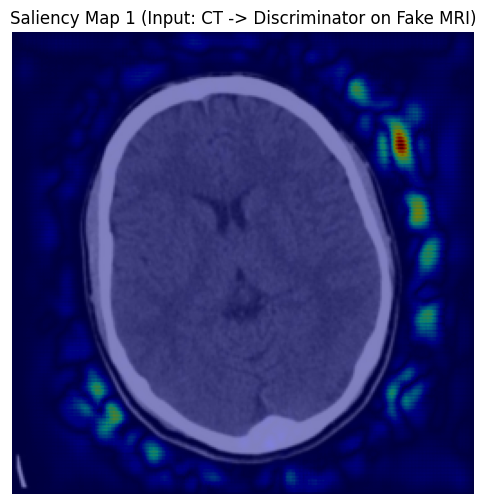

Saved saliency map: /kaggle/working/cyclegan_outputs/xai/saliency_001.png


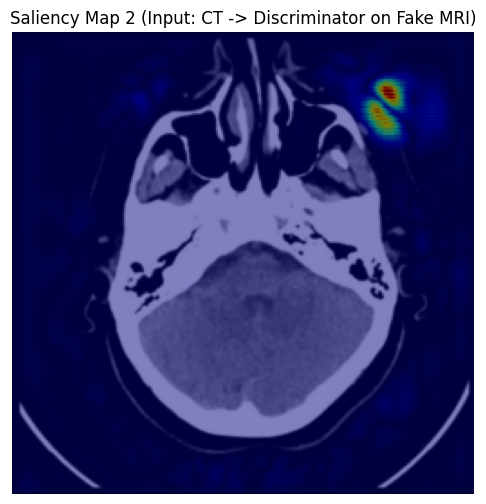

Saved saliency map: /kaggle/working/cyclegan_outputs/xai/saliency_002.png


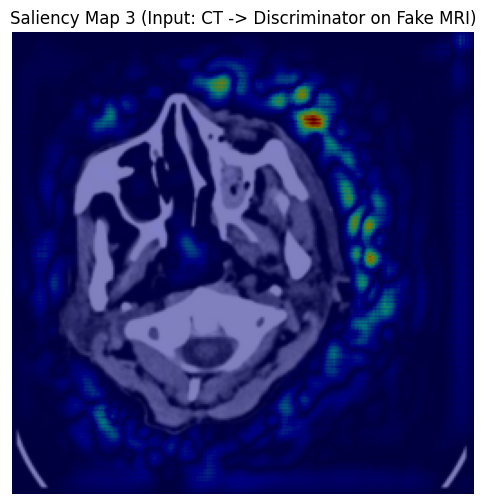

Saved saliency map: /kaggle/working/cyclegan_outputs/xai/saliency_003.png


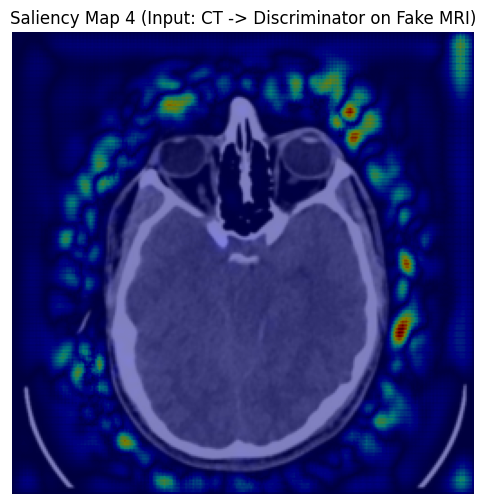

Saved saliency map: /kaggle/working/cyclegan_outputs/xai/saliency_004.png


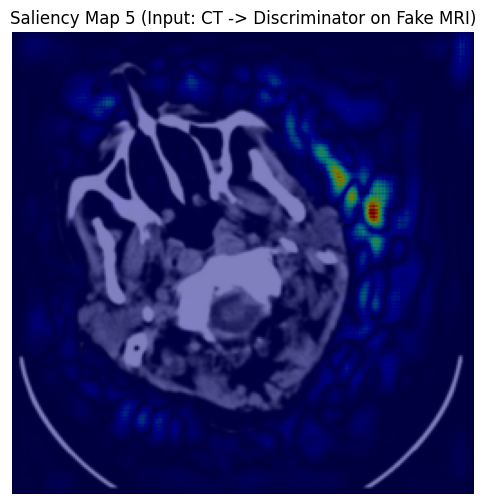

Saved saliency map: /kaggle/working/cyclegan_outputs/xai/saliency_005.png


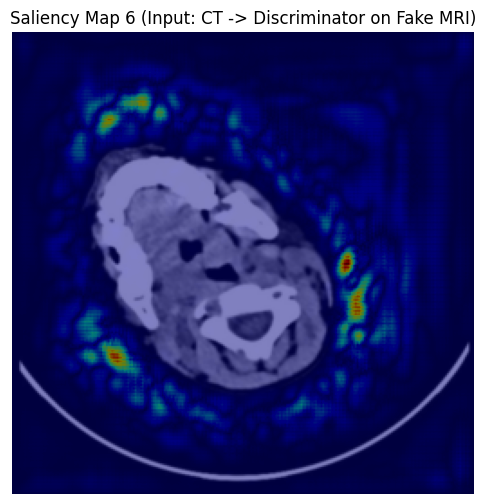

Saved saliency map: /kaggle/working/cyclegan_outputs/xai/saliency_006.png
✅ All saliency maps generated successfully at /kaggle/working/cyclegan_outputs/xai


In [44]:
# --- PHASE 1: Generate and Display all 6 Saliency Maps ---
print("--- PHASE 1: Saliency Maps ---")

try:
    # Ensure models are in eval mode
    netG_A2B.eval()
    netD_B.eval()

    # Loop over selected CT images
    for i, ct_p in enumerate(selected):
        pil_img = load_image_to_pil(ct_p)

        # Transform to tensor (expects RGB, normalized to [-1, 1])
        input_tensor = transform(pil_img).unsqueeze(0).to(device)
        input_tensor.requires_grad_(True)

        # Forward pass: CT -> fake MRI
        fake = netG_A2B(input_tensor)
        # Discriminator prediction on fake
        pred = netD_B(fake)
        # Score: mean prediction (higher for real-like)
        output_mean = pred.mean()
        
        # Backward pass
        netG_A2B.zero_grad()
        netD_B.zero_grad()
        output_mean.backward()

        # Compute saliency: max absolute gradient across channels w.r.t. input
        grad = input_tensor.grad.detach().abs()
        saliency = torch.max(grad.squeeze(0), dim=0)[0].cpu().numpy()  # (H, W)
        
        # Normalize saliency
        if saliency.max() > saliency.min():
            saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
        else:
            saliency = np.zeros_like(saliency)

        # Visualize input (denormalize to [0, 1] and permute to (H, W, C))
        img_vis = ((input_tensor.squeeze(0).detach().cpu() + 1.0) / 2.0).permute(1, 2, 0).numpy()  # Fixed: permute to (H,W,C)

        # Plot saliency overlay
        plt.figure(figsize=(6, 6))
        plt.imshow(img_vis)
        plt.imshow(saliency, cmap='jet', alpha=0.5)
        plt.title(f'Saliency Map {i+1} (Input: CT -> Discriminator on Fake MRI)')
        plt.axis('off')

        # Save
        save_path = os.path.join(xai_folder, f'saliency_{i+1:03d}.png')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.show() 

        print(f"Saved saliency map: {save_path}")

    print(f"✅ All saliency maps generated successfully at {xai_folder}")

except Exception as e:
    print(f"❌ Saliency visualization failed: {e}")
    import traceback
    traceback.print_exc()


--- PHASE 2: Grad-CAM Overlays ---


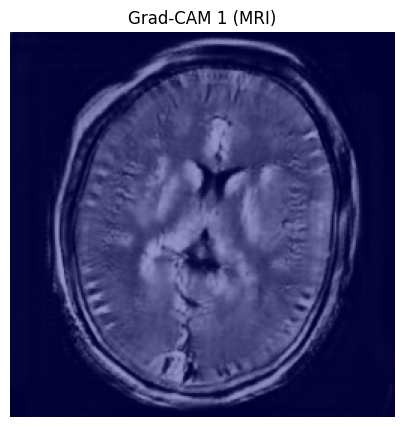

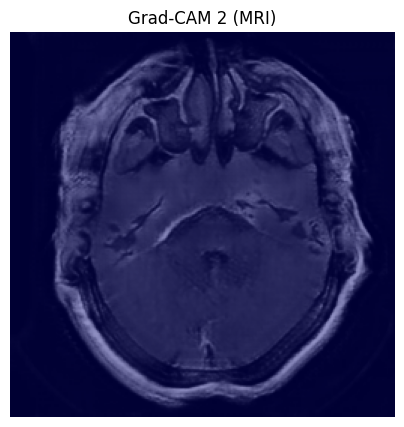

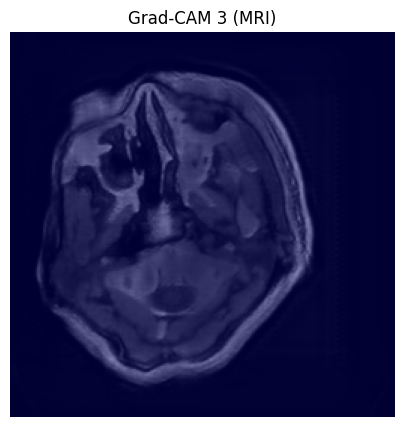

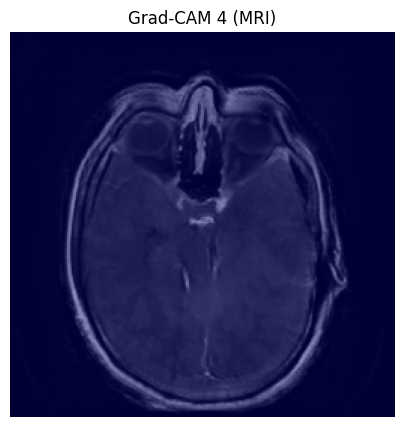

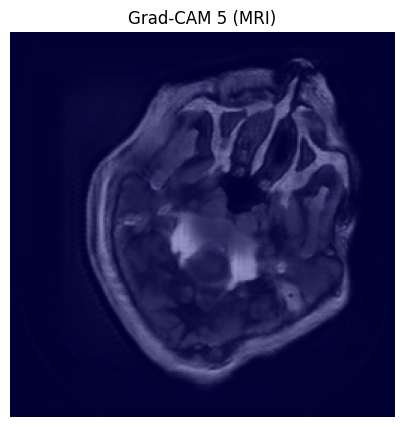

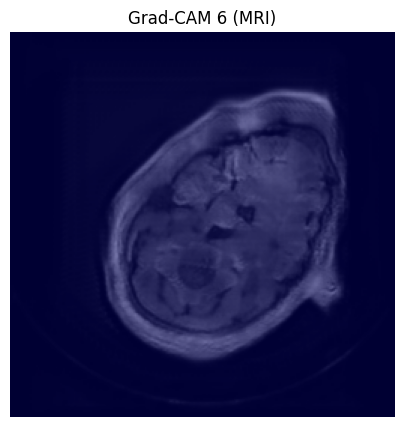

✅ Grad-CAM maps generated and saved to /kaggle/working/cyclegan_outputs/xai_gradcam


In [46]:
# --- PHASE 2: Generate and Display all 6 Grad-CAM Overlays ---
print("\n--- PHASE 2: Grad-CAM Overlays ---")

try:
    netG_A2B.eval()
    netD_B.eval()
    
    # GradCAM on discriminator (target last conv layer, adjust if needed for your discriminator arch)
    gradcam = GradCAM(netD_B, target_layer='model.7')  # Assuming PatchGAN with 'model.7' as final conv
    
    for i, ct_p in enumerate(selected):
        pil_img = load_image_to_pil(ct_p)
        sample_A = transform(pil_img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            fake_translated = netG_A2B(sample_A)
        
        # Compute Grad-CAM on fake (w.r.t. discriminator's output)
        cam_map = gradcam(fake_translated)
        
        # Overlay on fake MRI
        save_path = os.path.join(gradcam_folder, f"gradcam_fake_{i+1:03d}.png")
        overlay_heatmap_and_show(fake_translated[0], cam_map[0], save_path, title=f"Grad-CAM {i+1} (MRI)")
        
    gradcam.remove_hooks()
    print(f"✅ Grad-CAM maps generated and saved to {gradcam_folder}")

except Exception as e:
    print(f"❌ Grad-CAM visualization failed: {e}")
    import traceback
    traceback.print_exc()


--- PHASE 3: Feature Maps (Generator Activations) ---


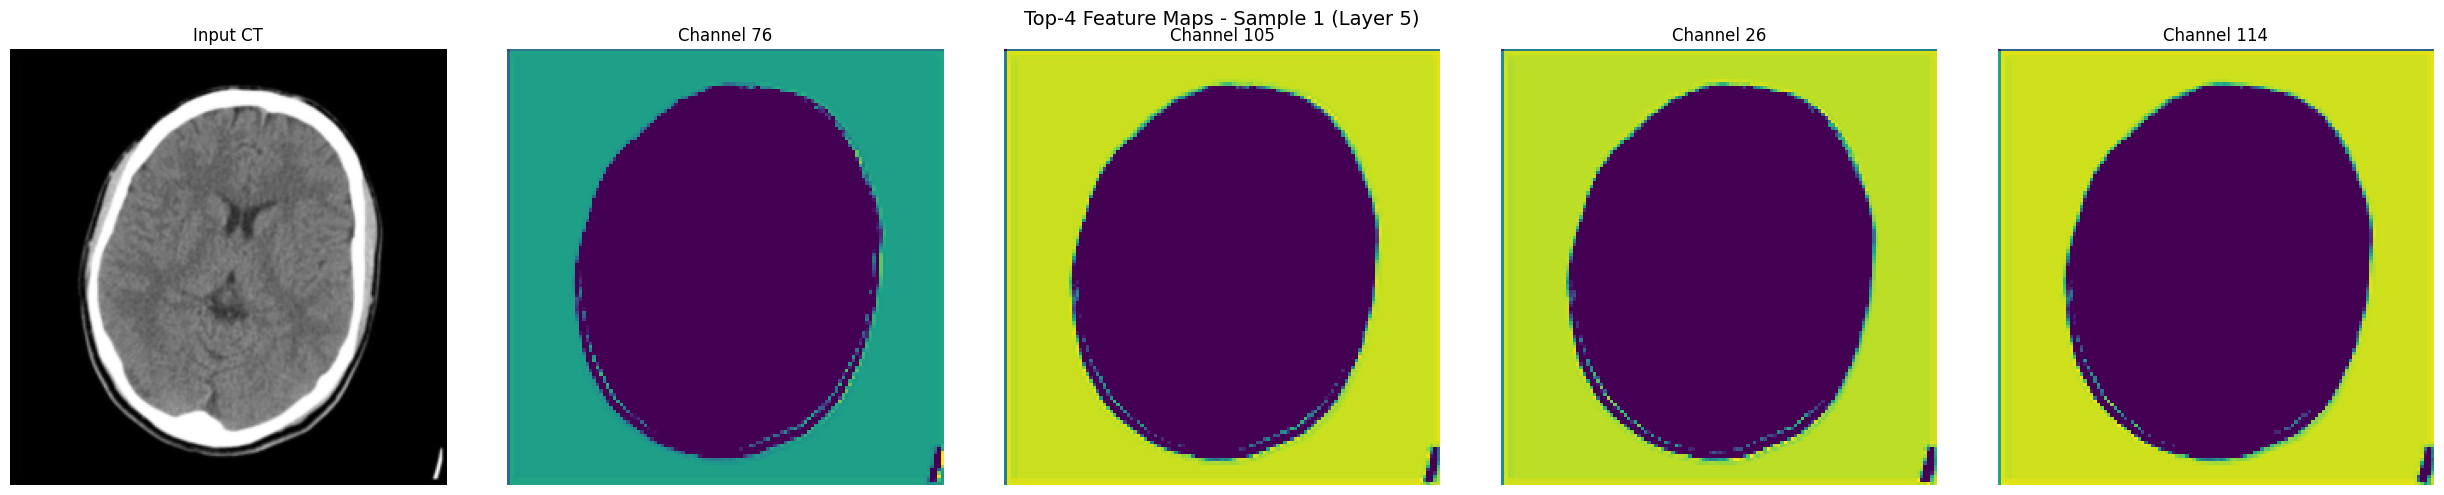

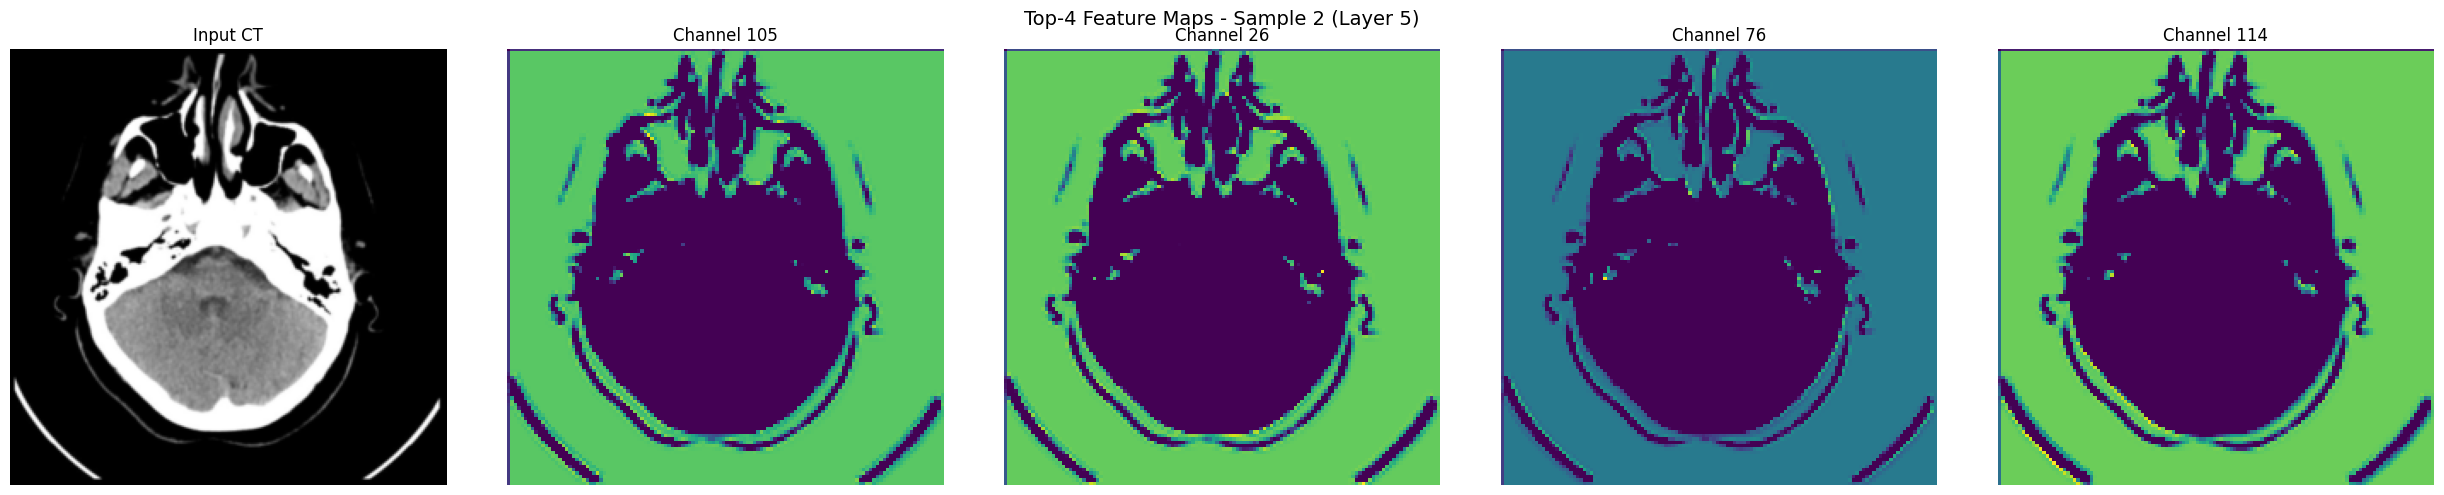

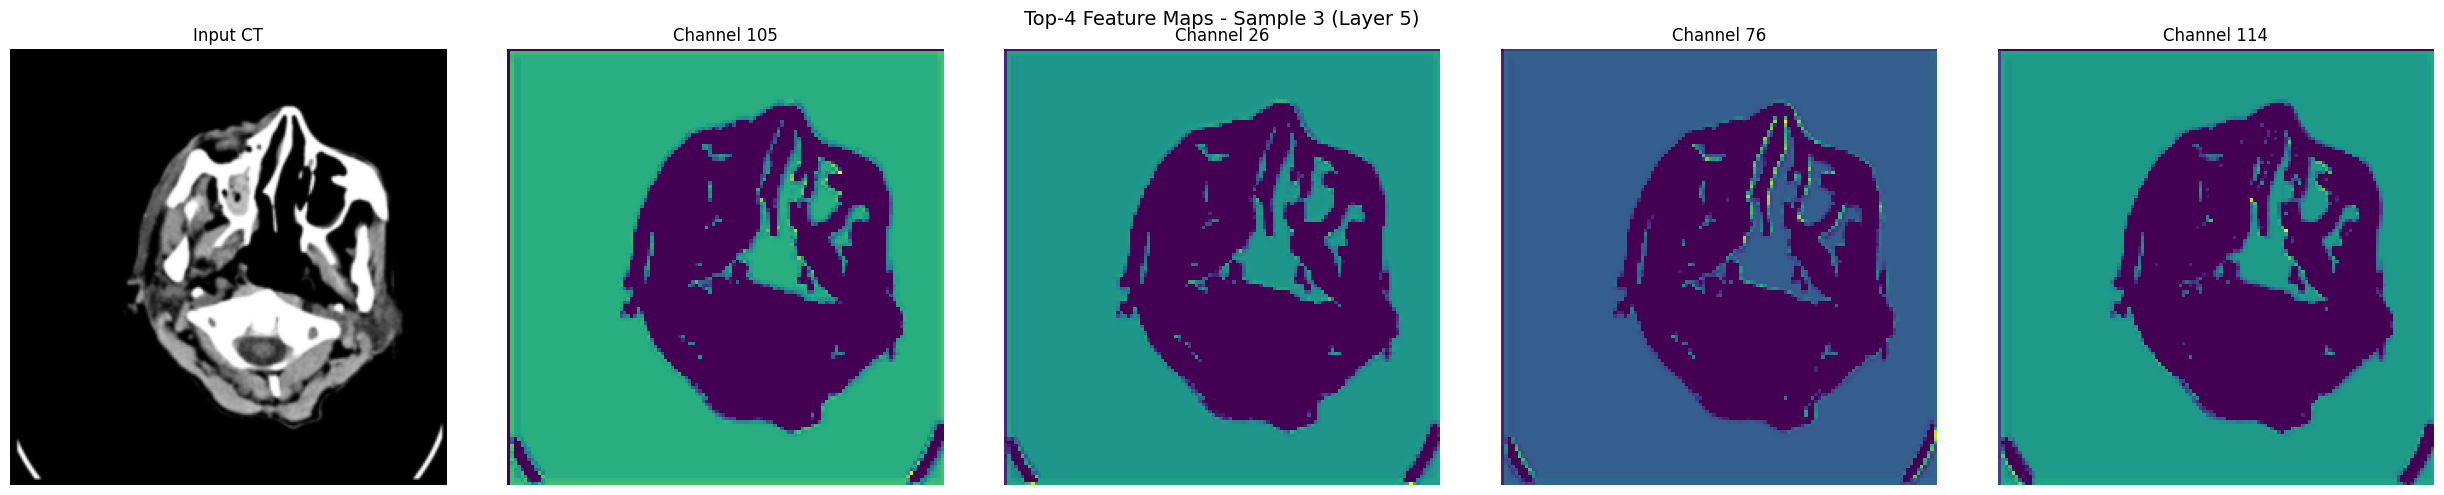

✅ Feature maps saved in: /kaggle/working/cyclegan_outputs/xai_featuremaps


In [48]:
# --- PHASE 3: Feature Maps (Generator Activations) ---
print("\n--- PHASE 3: Feature Maps (Generator Activations) ---")

# Fixed function (from your last cell, with minor tweaks for safety)
def visualize_feature_maps_cycleGAN(netG_A2B, real_A, device, num_samples=3, layer_index=5, save_dir='feature_maps'):
    """
    Visualize top-4 feature maps for CycleGAN generator along with input.
    layer_index: e.g., 5 for mid-layer in ResNetGenerator (adjust based on your model).
    """
    save_dir = os.path.join(OUT_DIR, save_dir)
    os.makedirs(save_dir, exist_ok=True)
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Register hook on the layer (netG_A2B.model is the ResNet model)
    if not hasattr(netG_A2B, 'model') or layer_index >= len(netG_A2B.model):
        raise ValueError(f"Layer {layer_index} not found in netG_A2B.model")
    layer = netG_A2B.model[layer_index]
    hook_handle = layer.register_forward_hook(get_activation(f'layer_{layer_index}'))

    netG_A2B.eval()
    with torch.no_grad():
        for i in range(num_samples):
            # Use batch sample (repeat if needed)
            img_idx = i % real_A.size(0)
            img = real_A[img_idx].unsqueeze(0).to(device)
            _ = netG_A2B(img)
            fmap = activation[f'layer_{layer_index}'].cpu().squeeze(0)  # (C, H, W)

            # Top-4 activated channels
            act_strength = fmap.view(fmap.shape[0], -1).abs().mean(dim=1)
            top_k = min(4, fmap.shape[0])
            top_indices = torch.topk(act_strength, top_k).indices

            # Input display
            img_disp = ((img[0].cpu() + 1.0) / 2.0).permute(1, 2, 0).numpy()  # Denorm to [0,1], (H,W,C)

            # Plot
            n_show = len(top_indices)
            fig, axes = plt.subplots(1, n_show + 1, figsize=(5 * (n_show + 1), 5))
            if n_show + 1 == 2:
                axes = [axes]  # Handle single subplot

            fig.suptitle(f"Top-{top_k} Feature Maps - Sample {i+1} (Layer {layer_index})", fontsize=14)

            # Input
            axes[0].imshow(img_disp)
            axes[0].set_title("Input CT")
            axes[0].axis('off')

            # Feature maps
            for j, idx in enumerate(top_indices):
                f = fmap[idx].numpy()
                f = (f - f.min()) / (f.max() - f.min() + 1e-8)
                axes[j + 1].imshow(f, cmap='viridis')
                axes[j + 1].set_title(f"Channel {idx.item()}")
                axes[j + 1].axis('off')

            plt.tight_layout()
            save_path = os.path.join(save_dir, f"sample_{i+1}_layer_{layer_index}.png")
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            plt.show()  # Display inline
            plt.close(fig)

    hook_handle.remove()
    print(f"✅ Feature maps saved in: {save_dir}")

try:
    # Fixed: Manually load a sample batch from 'selected' CT images (no need for undefined 'dataset')
    num_samples = 3
    real_A_list = []
    for i in range(min(num_samples, len(selected))):
        pil_img = load_image_to_pil(selected[i])
        img_tensor = transform(pil_img).unsqueeze(0)  # (1, C, H, W)
        real_A_list.append(img_tensor.squeeze(0))  # Remove batch dim to stack later
    
    real_A_sample = torch.stack(real_A_list, dim=0).to(device)  # (num_samples, C, H, W)
    
    # Visualize (layer_index=5 for mid-ResNet; adjust if needed)
    visualize_feature_maps_cycleGAN(netG_A2B, real_A_sample, device, num_samples=num_samples, layer_index=5, save_dir="xai_featuremaps")
    
except Exception as e:
    print(f"❌ Feature Map visualization failed: {e}")
    import traceback
    traceback.print_exc()